In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
from tqdm import tqdm
import seaborn as sns
sns.set(style = 'dark')
import matplotlib.pyplot as plt

### Loading image files

In [2]:
train_files_dir = glob('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/*')
test_files_dir = glob('/kaggle/input/siim-isic-melanoma-classification/jpeg/test/*')

### Loading Metadata

In [3]:
train_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test_df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')

In [4]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


## Imputing missing values & Feature Engineering

### Sex

Imputing mising values

In [6]:
train_df['sex'].fillna('unkown',inplace = True) # missing value

Label encoding

In [7]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

In [8]:
train_df['sex_enc'] = enc.fit_transform(train_df.sex.astype('str'))
test_df['sex_enc'] = enc.transform(test_df.sex.astype('str'))

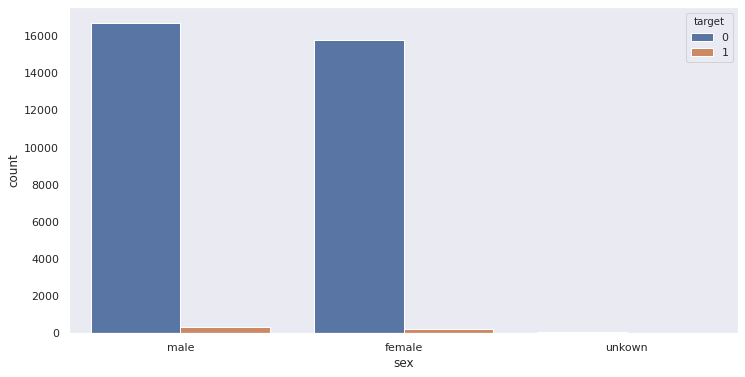

In [9]:
plt.figure(figsize = (12,6))
sns.countplot(x = 'sex', hue = 'target', data = train_df)

Let's check the encoding columns

In [10]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,sex_enc
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,1
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,0


### Anatom_site_general_challenge

Imputing missing values

In [11]:
test_df.anatom_site_general_challenge = test_df.anatom_site_general_challenge.fillna('unknown')
train_df.anatom_site_general_challenge = train_df.anatom_site_general_challenge.fillna('unknown')

Label encoding

In [12]:
train_df['anatom_enc']= enc.fit_transform(train_df.anatom_site_general_challenge.astype('str'))
test_df['anatom_enc']= enc.transform(test_df.anatom_site_general_challenge.astype('str'))

### Age

Imputing missing values

In [13]:
train_df['age_approx'] = train_df['age_approx'].fillna(train_df['age_approx'].mode().values[0])
test_df['age_approx']  = test_df['age_approx'].fillna(test_df['age_approx'].mode().values[0]) # Test data doesn't have any NaN in age_approx

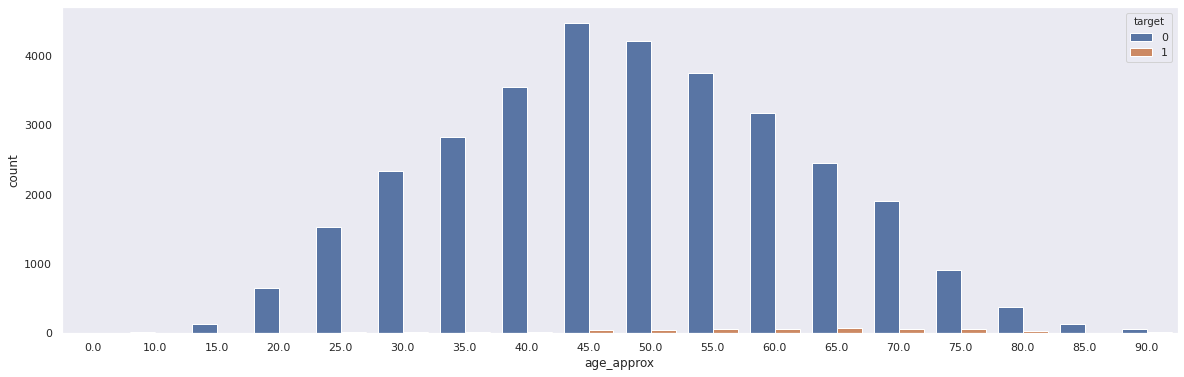

In [14]:
plt.figure(figsize = (20,6))
sns.countplot(x = 'age_approx', hue = 'target', data = train_df)

### Images Per Patient

In [15]:
train_df['n_images'] = train_df.patient_id.map(train_df.groupby(['patient_id']).image_name.count())
test_df['n_images'] = test_df.patient_id.map(test_df.groupby(['patient_id']).image_name.count())

### Image Size 

In [16]:
train_images = train_df['image_name'].values
train_sizes = np.zeros(train_images.shape[0])
for i, img_path in enumerate(tqdm(train_images)):
    train_sizes[i] = os.path.getsize(os.path.join('/kaggle/input/siim-isic-melanoma-classification/jpeg/train/', f'{img_path}.jpg'))
    
train_df['image_size'] = train_sizes


test_images = test_df['image_name'].values
test_sizes = np.zeros(test_images.shape[0])
for i, img_path in enumerate(tqdm(test_images)):
    test_sizes[i] = os.path.getsize(os.path.join('/kaggle/input/siim-isic-melanoma-classification/jpeg/test/', f'{img_path}.jpg'))
    
test_df['image_size'] = test_sizes

100%|██████████| 10982/10982 [00:02<00:00, 4206.81it/s]


### Scaling Image Size

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scale = MinMaxScaler()
train_df['image_size_scaled'] = scale.fit_transform(train_df['image_size'].values.reshape(-1, 1))
test_df['image_size_scaled'] = scale.transform(test_df['image_size'].values.reshape(-1, 1))

### Min-Max age of Patient

In [18]:
train_df['age_id_min']  = train_df['patient_id'].map(train_df.groupby(['patient_id']).age_approx.min())
train_df['age_id_max']  = train_df['patient_id'].map(train_df.groupby(['patient_id']).age_approx.max())

test_df['age_id_min']  = test_df['patient_id'].map(test_df.groupby(['patient_id']).age_approx.min())
test_df['age_id_max']  = test_df['patient_id'].map(test_df.groupby(['patient_id']).age_approx.max())

## Training the model

In [19]:
features = [
            'age_approx',
            'age_id_min',
            'age_id_max',
            'sex_enc',
            'anatom_enc',
            'n_images',
            'image_size_scaled',
           ]

In [20]:
X = train_df[features]
y = train_df['target']

X_test = test_df[features]

In [21]:
# Load libraries for training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

### Training Xgboost with Stratified K-Fold Cross Validation

In [22]:
model = XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.002, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=None, monotone_constraints=None,
             n_estimators=700, n_jobs=-1, nthread=-1, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, silent=True, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

kfold = StratifiedKFold(n_splits=5, random_state=1001, shuffle=True)
cv_results = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc', verbose = 3)
cv_results.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] .................................... , score=0.834, total=  15.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s remaining:    0.0s


[CV] .................................... , score=0.815, total=  15.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.6s remaining:    0.0s


[CV] .................................... , score=0.836, total=  16.2s
[CV]  ................................................................
[CV] .................................... , score=0.856, total=  15.7s
[CV]  ................................................................
[CV] .................................... , score=0.830, total=  15.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min finished


0.8339546070357212

### Training on entire data for making predictions

In [23]:
model.fit(X,y)
pred_xgb = model.predict(X_test)

### Feature Importance

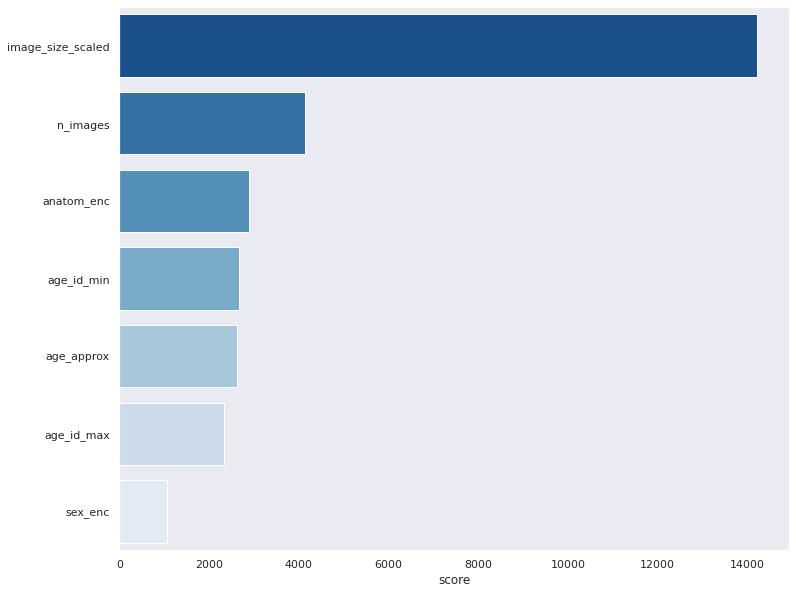

In [24]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
plt.figure(figsize= (12,10))
sns.barplot(x = data.score , y = data.index, orient = 'h', palette = 'Blues_r')

### Creating submission file

In [25]:
sub = pd.DataFrame({'image_name':test_df.image_name.values,
                    'target':pred_xgb})
sub.to_csv('submission.csv',index = False)